**CLASSIFICATION OF PNEUMONIA AND NORMAL PERSONS USING X-RAYS WITH CNN**

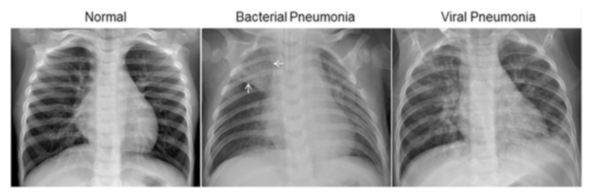

 Illustrative Examples of Chest X-Rays in Patients with Pneumonia, Related to  The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Content The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

**IMPORTING THE LIBRARIES** 

In [ ]:
import cv2,os
import numpy as np
import tensorflow
import keras
from sklearn.preprocessing import LabelEncoder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

## Data Pre-processing

In [ ]:
#### To load image data with labels in folder
def load_data(path):
    files = np.array(os.listdir(path))
    if "NORMAL" in path:
        labels = np.array(['normal']*len(files))
    else:
        labels = np.array([file.split('_')[1] for file in files])

    images = []
    img_size=100
    img_names=os.listdir(path)
    for img_name in img_names:
        img_path=os.path.join(path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            images.append(resized)
        except Exception as e:
            print('Exception:',e)
            
    images = np.array(images)/255
    images=np.reshape(images,(images.shape[0],img_size,img_size,1))
    return images, labels

### Training Data

In [ ]:
### load data using above function
norm_images, norm_labels=load_data("/content/drive/My Drive/chest_xray/train/NORMAL")
pneu_images, pneu_labels = load_data("/content/drive/My Drive/chest_xray/train/PNEUMONIA") 

In [ ]:
### Append all the data
x_train= np.append(norm_images,pneu_images,axis=0)
y_train = np.append(norm_labels,pneu_labels)

In [ ]:
### Get frequency distribution of each class
count=np.unique(y_train ,return_counts=True)

In [ ]:
import matplotlib.pyplot as plt

<BarContainer object of 3 artists>

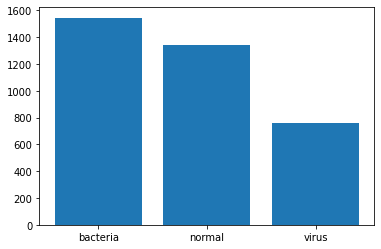

In [ ]:
plt.bar(count[0],count[1])

In [ ]:
LabelEncoder=LabelEncoder()

In [ ]:
y_train = LabelEncoder.fit_transform(y_train)
y_train

array([1, 1, 1, ..., 2, 0, 0])

0: Bacteria

1.   List item
2.   List item


1: Normal
2: virus

### Testing Data

In [ ]:
### load test dataset
norm_images_test, norm_labels_test=load_data("/content/drive/My Drive/chest_xray/test/NORMAL")
pneu_images_test, pneu_labels_test = load_data("/content/drive/My Drive/chest_xray/test/PNEUMONIA")

In [ ]:
## combine images and use label encoder on test data
x_test= np.append(norm_images_test,pneu_images_test,axis=0)
y_test = np.append(norm_labels_test,pneu_labels_test)
y_test=LabelEncoder.fit_transform(y_test)

### Validation data 

In [ ]:
### load test dataset
norm_images_val, norm_labels_val=load_data("/content/drive/My Drive/chest_xray/val/NORMAL")
pneu_images_val, pneu_labels_val = load_data("/content/drive/My Drive/chest_xray/val/PNEUMONIA")

In [ ]:
## combine images and use label encoder on test data
x_val= np.append(norm_images_val,pneu_images_val,axis=0)
y_val = np.append(norm_labels_val,pneu_labels_val)
y_val=LabelEncoder.fit_transform(y_val)

## Model Building and training

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.metrics import accuracy_score , confusion_matrix

In [ ]:
## define model architecture
model=Sequential()
model.add(Conv2D(200,(3,3) ,input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3),activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second CNN layer followed by Relu and MaxPooling layers


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
##Dence layer of 50 neurons           

model.add(Dense(3,activation='softmax'))
## final layer with 3 output categories

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 200)       2000      
_________________________________________________________________
activation (Activation)      (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 52900)             0

In [ ]:
## train model for 16 epochs
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_accuracy',verbose=0,save_best_only=True,mode='auto')
history=model.fit(x_train,y_train,epochs=16,callbacks=[checkpoint],validation_data=(x_test,y_test))

Epoch 1/16
114/114 [==============================] - 263s 2s/step - loss: 0.9021 - accuracy: 0.5749 - val_loss: 1.0537 - val_accuracy: 0.4470
INFO:tensorflow:Assets written to: model-001.model/assets
Epoch 2/16
114/114 [==============================] - 260s 2s/step - loss: 0.5011 - accuracy: 0.7865 - val_loss: 1.0713 - val_accuracy: 0.4470
Epoch 3/16
114/114 [==============================] - 259s 2s/step - loss: 0.4908 - accuracy: 0.7835 - val_loss: 0.8414 - val_accuracy: 0.5227
INFO:tensorflow:Assets written to: model-003.model/assets
Epoch 4/16
114/114 [==============================] - 259s 2s/step - loss: 0.4572 - accuracy: 0.8028 - val_loss: 0.8155 - val_accuracy: 0.5303
INFO:tensorflow:Assets written to: model-004.model/assets
Epoch 5/16
114/114 [==============================] - 258s 2s/step - loss: 0.4316 - accuracy: 0.8168 - val_loss: 0.9758 - val_accuracy: 0.4924
Epoch 6/16
114/114 [==============================] - 257s 2s/step - loss: 0.3895 - accuracy: 0.8154 - val_loss

## Model evaluation

In [ ]:
##used for prediction of X_test
y_pred=model.predict(x_val)

Model.predict is giving the probabilities that the datapoint belong to perticular class

In [ ]:
### assign label having max probability
new_y_pred=[] 
for value in y_pred:
    abc = list(value)
    ind = abc.index(max(value))
    if ind==0:
        new_y_pred.append(0)
    elif ind==1:
        new_y_pred.append(1)
    elif ind==2:
        new_y_pred.append(2)

In [ ]:
new_y_pred

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0]

In [ ]:
## acuracy score and confusion matrix without balancing data
print("without balancing of data confusion matrix:" ,confusion_matrix(y_val,new_y_pred))
print("without balancing of data Accuracy Score:",accuracy_score(y_val,new_y_pred))

without balancing of data confusion matrix: [[6 0 2]
 [0 8 0]
 [0 0 0]]
without balancing of data Accuracy Score: 0.875


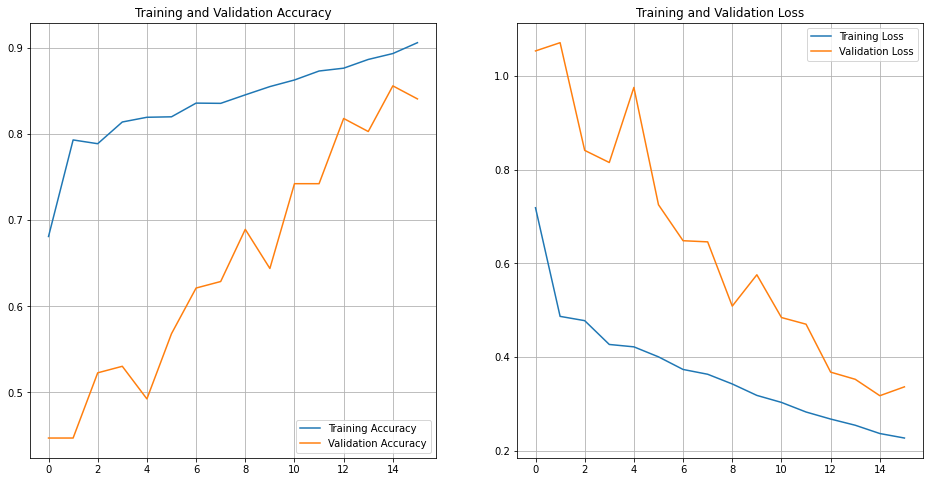

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.show()

**The model is performing with 84% accuracy to classify  the images into given categories .**

In [ ]:
from keras.models import load_model

model.save('model_lung.h5')

In [ ]:
pwd

'/content'